In [1]:
# Step 1: Load dataset with both predictions
import pandas as pd

df = pd.read_csv('../data/processed/device_insurance_with_severity_predictions.csv')

# Step 2: Calculate Technical Premium
df['Technical_Premium'] = df['Predicted_Claim_Frequency'] * df['Predicted_Claim_Severity']

# Optional: Add a column for margin calculation (if you have actual plan prices)
# df['Margin'] = df['Plan_Price'] - df['Technical_Premium']

# Step 3: Save technical pricing table
df.to_csv('../data/processed/device_insurance_with_technical_premium.csv', index=False)
print("Technical premium table saved to: ../data/processed/device_insurance_with_technical_premium.csv")

# Step 4: Preview
df[['Policy_ID', 'Predicted_Claim_Frequency', 'Predicted_Claim_Severity', 'Technical_Premium']].head()

Technical premium table saved to: ../data/processed/device_insurance_with_technical_premium.csv


,Policy_ID,Predicted_Claim_Frequency,Predicted_Claim_Severity,Technical_Premium
0,P000001,0.155367,77.821158,12.090822
1,P000002,0.368593,77.821158,28.684334
2,P000003,0.278405,77.821158,21.665838
3,P000004,0.204975,77.821158,15.951417
4,P000005,0.324654,77.821158,25.264951


In [2]:
# Step 1: Load technical premium file
import pandas as pd

df = pd.read_csv('../data/processed/device_insurance_with_technical_premium.csv')

# Step 2: Create base final premium (e.g. 25% loading)
df['Final_Premium_Base'] = df['Technical_Premium'] * 1.25

# Step 3: Young customer (18–25) gets a 10% surcharge
df['Final_Premium_YoungLoad'] = df['Final_Premium_Base']
df.loc[df['Age_Band'] == '18-25', 'Final_Premium_YoungLoad'] *= 1.10

# Step 4: Tablet devices get a 10% discount
df['Final_Premium_TabletDisc'] = df['Final_Premium_YoungLoad']
df.loc[df['Device_Type'] == 'Tablet', 'Final_Premium_TabletDisc'] *= 0.90

# Step 5: Rename final column to show as main
df['Final_Premium'] = df['Final_Premium_TabletDisc']

# Step 6: Save file
df.to_csv('../data/processed/device_insurance_with_final_premium.csv', index=False)
print("Final premium scenarios saved to: ../data/processed/device_insurance_with_final_premium.csv")

# Step 7: Preview
df[['Policy_ID', 'Technical_Premium', 'Final_Premium']].head()

Final premium scenarios saved to: ../data/processed/device_insurance_with_final_premium.csv


,Policy_ID,Technical_Premium,Final_Premium
0,P000001,12.090822,15.113528
1,P000002,28.684334,35.855417
2,P000003,21.665838,27.082297
3,P000004,15.951417,19.939272
4,P000005,25.264951,31.581188


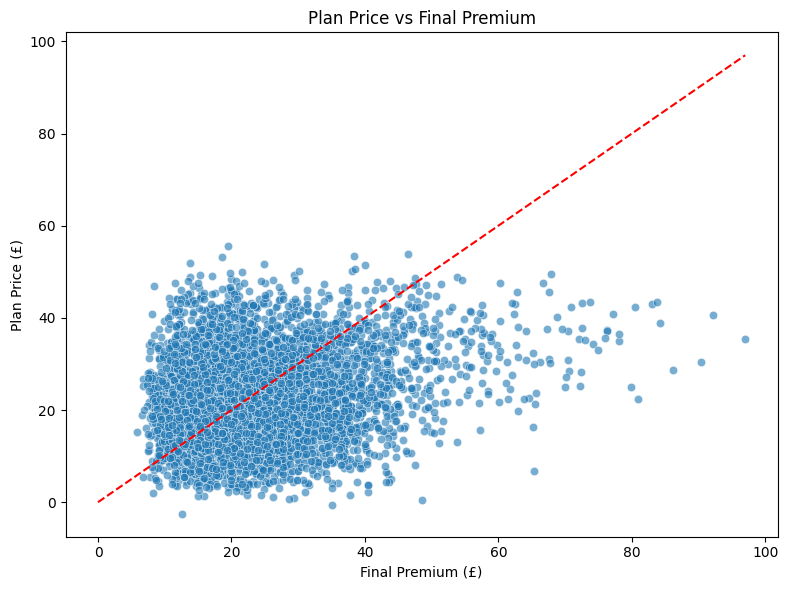

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset if not already
df = pd.read_csv('../data/processed/device_insurance_with_final_premium.csv')

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Final_Premium',
    y='Plan_Price',
    data=df,
    alpha=0.6
)
plt.plot([0, df['Final_Premium'].max()], [0, df['Final_Premium'].max()], color='red', linestyle='--')
plt.xlabel('Final Premium (£)')
plt.ylabel('Plan Price (£)')
plt.title('Plan Price vs Final Premium')
plt.savefig('../reports/figures/final_vs_plan_price.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [4]:
# Load data
import pandas as pd
df = pd.read_csv('../data/processed/device_insurance_with_final_premium.csv')

# Set a buffer to ignore minor differences (e.g. £2 tolerance)
tolerance = 2.0

# Categorize pricing alignment
df['Pricing_Position'] = df.apply(
    lambda row: 'Overpriced' if row['Plan_Price'] - row['Final_Premium'] > tolerance else
                'Underpriced' if row['Final_Premium'] - row['Plan_Price'] > tolerance else
                'Aligned',
    axis=1
)

# Count of each category
pricing_counts = df['Pricing_Position'].value_counts()

# Percentage breakdown
pricing_percentages = df['Pricing_Position'].value_counts(normalize=True) * 100

# Combine and display
pricing_summary = pd.DataFrame({
    'Policy_Count': pricing_counts,
    'Percentage': pricing_percentages.round(2)
})

print(pricing_summary)

                  Policy_Count  Percentage
Pricing_Position                          
Underpriced               2398       47.96
Overpriced                1954       39.08
Aligned                    648       12.96


In [5]:
import pandas as pd

# Load your file
df = pd.read_csv('../data/processed/device_insurance_with_final_premium.csv')

# Step 1: Calculate Margin & Margin %
df['Margin'] = df['Plan_Price'] - df['Final_Premium']
df['Margin_Percent'] = df['Margin'] / df['Final_Premium'] * 100

# Step 2: Calculate Portfolio-level Metrics
total_final_premium = df['Final_Premium'].sum()
total_claim_cost = df['Claim_Cost'].sum()

portfolio_margin = df['Margin'].sum()
portfolio_margin_percent = portfolio_margin / total_final_premium * 100
portfolio_loss_ratio = total_claim_cost / total_final_premium

# Step 3: Display Results
print(f" Total Final Premium Collected: £{total_final_premium:,.2f}")
print(f" Total Claim Cost Paid: £{total_claim_cost:,.2f}")
print(f" Portfolio-Level Margin: £{portfolio_margin:,.2f} ({portfolio_margin_percent:.2f}%)")
print(f" Portfolio-Level Loss Ratio: {portfolio_loss_ratio:.2f}")

 Total Final Premium Collected: £121,733.91
 Total Claim Cost Paid: £95,969.37
 Portfolio-Level Margin: £-8,661.83 (-7.12%)
 Portfolio-Level Loss Ratio: 0.79


In [7]:
import pandas as pd

# Load data
df = pd.read_csv('../data/processed/device_insurance_with_final_premium.csv')

# Calculate margin if not already done
df['Margin'] = df['Plan_Price'] - df['Final_Premium']

df['Margin_Percent'] = df['Margin'] / df['Final_Premium'] * 100

# Choose grouping level
group_col = 'Device_Type'   # ← change to 'Age_Band' if needed

# Grouped metrics
group_summary = df.groupby(group_col).agg(
    Policy_Count=('Policy_ID', 'count'),
    Total_Final_Premium=('Final_Premium', 'sum'),
    Total_Claim_Cost=('Claim_Cost', 'sum'),
    Total_Margin=('Margin', 'sum')
)

# Derived metrics
group_summary['Loss_Ratio'] = group_summary['Total_Claim_Cost'] / group_summary['Total_Final_Premium']
group_summary['Margin_%'] = group_summary['Total_Margin'] / group_summary['Total_Final_Premium'] * 100

# Round values
group_summary = group_summary.round({
    'Total_Final_Premium': 2,
    'Total_Claim_Cost': 2,
    'Total_Margin': 2,
    'Loss_Ratio': 2,
    'Margin_%': 2
})

# Display
group_summary.reset_index(inplace=True)
group_summary.sort_values(by='Loss_Ratio', ascending=False, inplace=True)
group_summary

,Device_Type,Policy_Count,Total_Final_Premium,Total_Claim_Cost,Total_Margin,Loss_Ratio,Margin_%
3,Phone,643,17499.96,18120.42,3903.74,1.04,22.31
2,Laptop,622,21669.35,22351.25,-1030.59,1.03,-4.76
6,Tablet,609,12428.34,8900.15,-990.81,0.72,-7.97
4,Refrigerator,619,14590.46,9996.03,-2784.44,0.69,-19.08
1,Headphones,638,15235.77,10167.67,-2957.58,0.67,-19.41
0,Charger,628,13901.19,9150.18,-2082.26,0.66,-14.98
5,TV,616,12884.96,8486.66,-1144.03,0.66,-8.88
7,Washing Machine,625,13523.88,8797.01,-1575.86,0.65,-11.65


In [8]:
group_col = 'Vendor'

vendor_summary = df.groupby(group_col).agg(
    Policy_Count=('Policy_ID', 'count'),
    Total_Final_Premium=('Final_Premium', 'sum'),
    Total_Claim_Cost=('Claim_Cost', 'sum'),
    Total_Margin=('Margin', 'sum')
)

vendor_summary['Loss_Ratio'] = vendor_summary['Total_Claim_Cost'] / vendor_summary['Total_Final_Premium']
vendor_summary['Margin_%'] = vendor_summary['Total_Margin'] / vendor_summary['Total_Final_Premium'] * 100

vendor_summary = vendor_summary.round(2).sort_values(by='Loss_Ratio', ascending=False).reset_index()
vendor_summary

,Vendor,Policy_Count,Total_Final_Premium,Total_Claim_Cost,Total_Margin,Loss_Ratio,Margin_%
0,AO.com,1016,23098.23,18818.04,-275.34,0.81,-1.19
1,Argos,993,26085.64,20813.87,-3899.25,0.80,-14.95
2,John Lewis,975,22517.73,17872.88,-100.84,0.79,-0.45
3,Amazon UK,1014,25440.83,19937.76,-2384.44,0.78,-9.37
4,Currys,1002,24591.48,18526.82,-2001.96,0.75,-8.14


In [9]:
group_col = 'Region'

region_summary = df.groupby(group_col).agg(
    Policy_Count=('Policy_ID', 'count'),
    Total_Final_Premium=('Final_Premium', 'sum'),
    Total_Claim_Cost=('Claim_Cost', 'sum'),
    Total_Margin=('Margin', 'sum')
)

region_summary['Loss_Ratio'] = region_summary['Total_Claim_Cost'] / region_summary['Total_Final_Premium']
region_summary['Margin_%'] = region_summary['Total_Margin'] / region_summary['Total_Final_Premium'] * 100

region_summary = region_summary.round(2).sort_values(by='Loss_Ratio', ascending=False).reset_index()
region_summary

,Region,Policy_Count,Total_Final_Premium,Total_Claim_Cost,Total_Margin,Loss_Ratio,Margin_%
0,Scotland,836,20674.09,16646.71,-1797.58,0.81,-8.69
1,London,828,20793.09,16558.26,-1645.64,0.80,-7.91
2,North West,812,18482.89,14860.24,-437.07,0.80,-2.36
3,South East,859,21172.88,16739.72,-1702.05,0.79,-8.04
4,Wales,833,19209.21,14969.08,-510.26,0.78,-2.66
5,West Midlands,832,21401.75,16195.36,-2569.23,0.76,-12.00


C:\Users\atul1\AppData\Local\Temp\ipykernel_33232\2420972601.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vendor_sorted, x='Loss_Ratio', y='Vendor', palette='coolwarm')


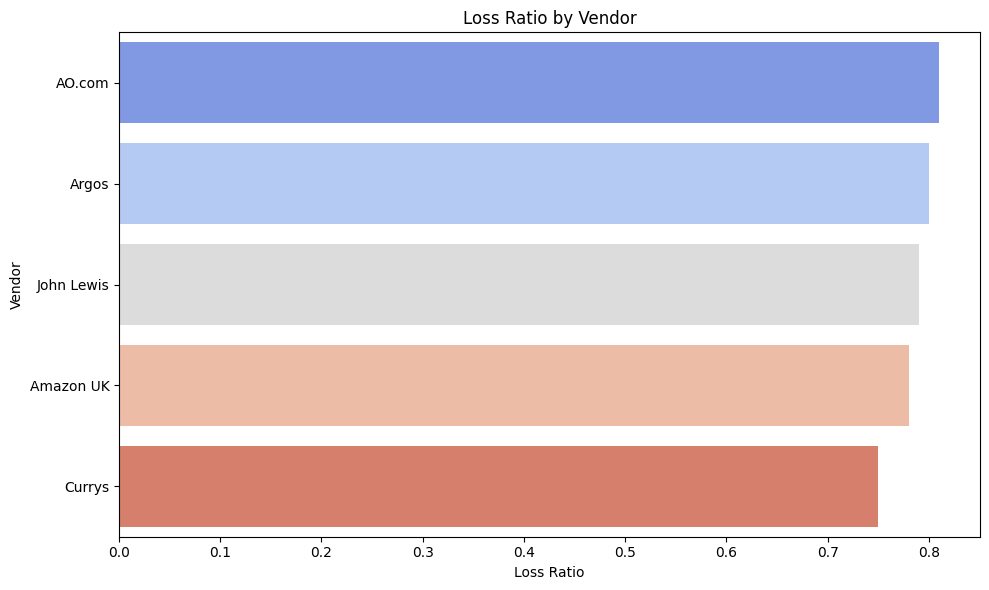

C:\Users\atul1\AppData\Local\Temp\ipykernel_33232\2420972601.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vendor_sorted, x='Margin_%', y='Vendor', palette='viridis')


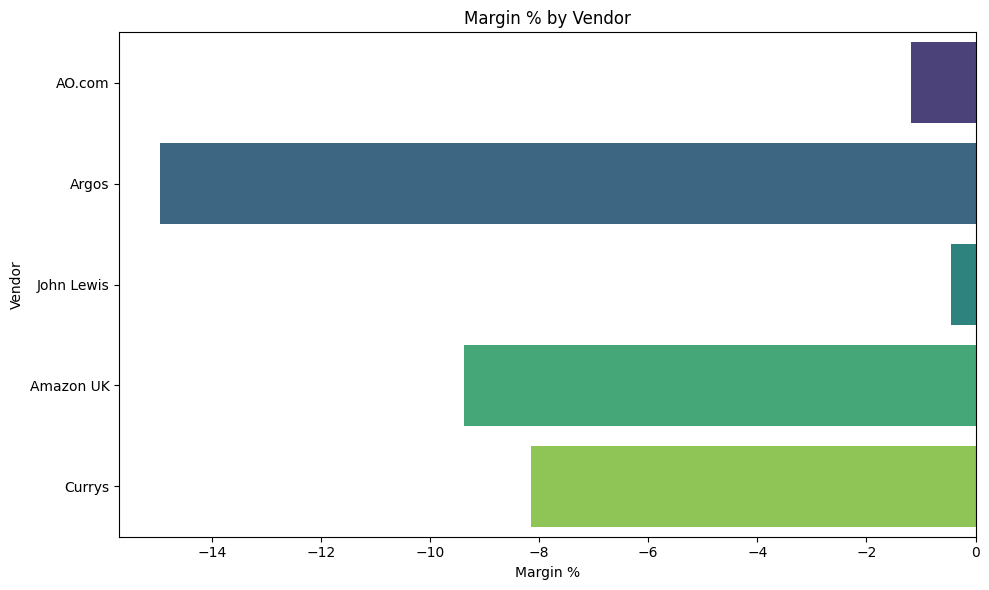

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by Loss Ratio
vendor_sorted = vendor_summary.sort_values(by='Loss_Ratio', ascending=False)

# Loss Ratio Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=vendor_sorted, x='Loss_Ratio', y='Vendor', palette='coolwarm')
plt.title('Loss Ratio by Vendor')
plt.xlabel('Loss Ratio')
plt.ylabel('Vendor')
plt.tight_layout()
plt.show()

# Margin % Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=vendor_sorted, x='Margin_%', y='Vendor', palette='viridis')
plt.title('Margin % by Vendor')
plt.xlabel('Margin %')
plt.ylabel('Vendor')
plt.savefig('../reports/figures/loss_by_vendor.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

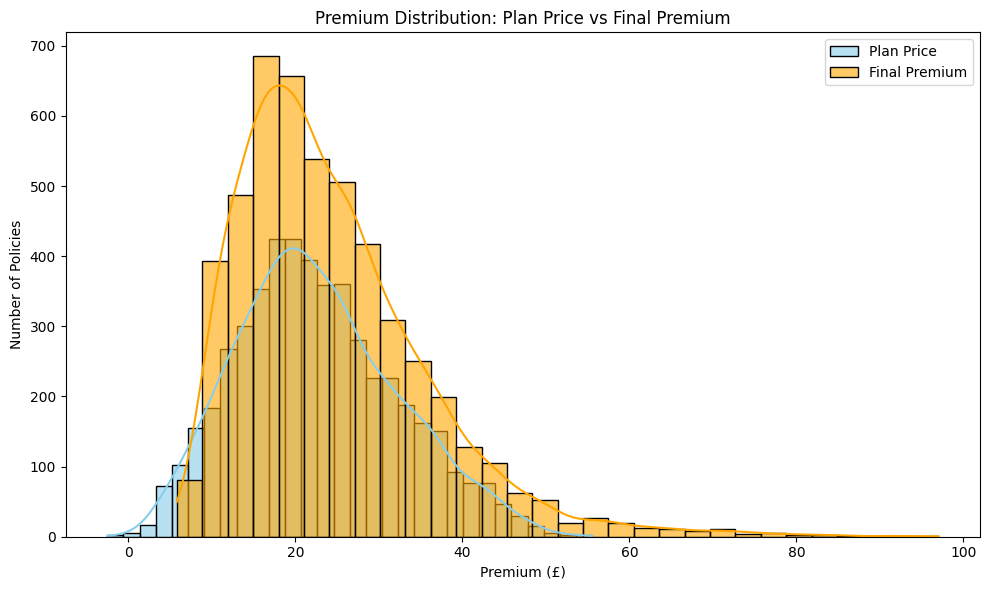

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load data (if not already loaded)
df = pd.read_csv('../data/processed/device_insurance_with_final_premium.csv')

plt.figure(figsize=(10, 6))
sns.histplot(df['Plan_Price'], bins=30, color='skyblue', label='Plan Price', kde=True, alpha=0.6)
sns.histplot(df['Final_Premium'], bins=30, color='orange', label='Final Premium', kde=True, alpha=0.6)

plt.title('Premium Distribution: Plan Price vs Final Premium')
plt.xlabel('Premium (£)')
plt.ylabel('Number of Policies')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/premium_distribution_plot.png', bbox_inches='tight')
plt.show()

C:\Users\atul1\AppData\Local\Temp\ipykernel_33232\332349271.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


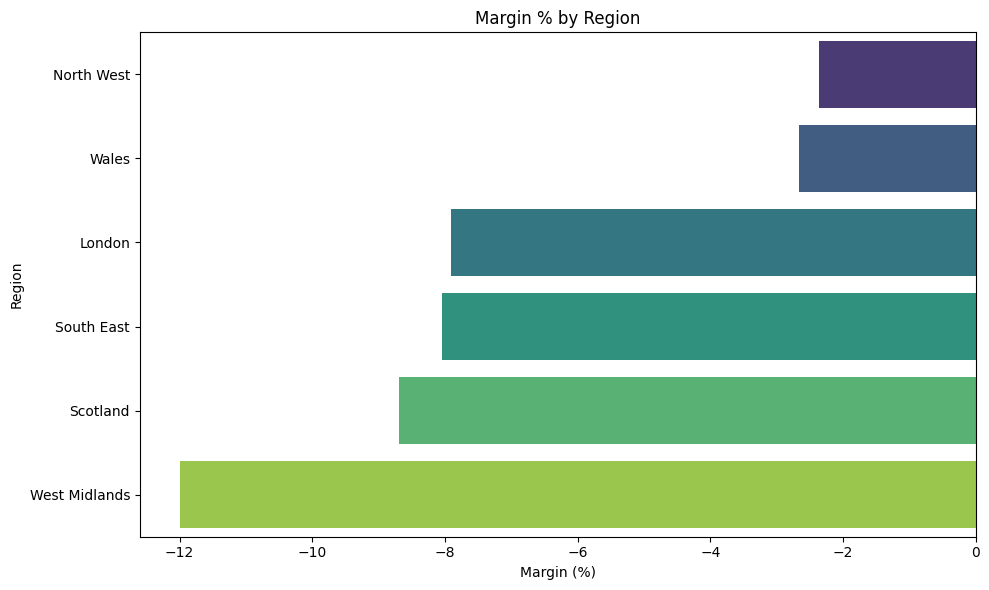

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# If not sorted already
region_sorted = region_summary.sort_values(by='Margin_%', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=region_sorted,
    x='Margin_%',
    y='Region',
    palette='viridis'
)
plt.title('Margin % by Region')
plt.xlabel('Margin (%)')
plt.ylabel('Region')
plt.tight_layout()
plt.savefig('../reports/figures/margin_percent_by_region.png', bbox_inches='tight')
plt.show()